# Notebook Overview : Recovery score and Regression

# Notebook Overview : Recovery score and Regression

This notebook computes the recovery score as a measure of motor recovery and performs a linear regression with acute (T1) scores as independent
variables and recovery scores as dependent variable. \
Content : 

About recovery score :
- Recovery score computation for all domains
- Visualization of its distribution
- A comparison between recovery scores and longitudinal motor labels
- visualization of patients having a negative motor recovery
- removal of patients having a motor score below 0.02 and visualization of their correlations with motor score.

About linear regression :
- informations about predictors : distribution, correlation between each predictor, correlation between each predictor and the variable of interest *motor_recovery*
- First regression model with every predictors
- Influencial plot showing the most influencial points of the preceding model


This notebook has to be run after *Longitudinal_clustering_motor.ipynb* \
Be careful to have the variable *LAST_scores_no_language* set to the same value in both *Longitudinal_clustering_motor.ipynb* and *Regression.ipynb*

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr

# To make this notebook's output stable across runs
np.random.seed(255)

#To ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Choice of dataset
LAST_scores_no_language = False

# Choice of preprocessing
remove_negative = False
remove_good_performers = True

In [3]:
domains = ["motor", "attention", "executive", "sensory", "language", "neglect"]
n_domains = len(domains)

# Import the dataset from longitudinal clustering

In [4]:
root = r'../Data/Longitudinal/NMF_per_timepoint'
if LAST_scores_no_language:
    root = root + 'only_LAST_'


NMF = pd.read_csv(root+'.csv').drop(columns=['Unnamed: 0'])

#Change label column type for statistics purposes
NMF['Labels'] = NMF['Labels'].astype(str)
NMF["longitudinal_motor_labels"] = NMF["longitudinal_motor_labels"].astype(str)
NMF["time"]= NMF["time"].astype(str)

display(NMF.head())

,motor,attention,executive,sensory,language,neglect,Patient,Labels,time,time_in_weeks,longitudinal_motor_labels
0,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,P001,0,1,1,0
1,0.003425,0.170126,0.328080,0.000000,0.300511,0.047076,P001,0,2,3,0
2,0.003898,0.204180,0.213347,0.010526,0.243593,0.017072,P001,0,3,12,0
3,0.003055,0.177056,0.248852,0.000000,0.267846,0.014714,P001,0,4,52,0
4,0.036073,0.179785,0.332524,0.000000,0.210102,0.037255,P002,0,1,1,0


In [5]:
# Generate a colormap with unique colors for each label
color_labels = NMF['longitudinal_motor_labels'].unique()
col_values = sns.color_palette('Set2')
colormap = dict(zip(color_labels, col_values))
print(colormap)

{'0': (0.4, 0.7607843137254902, 0.6470588235294118), '1': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), '2': (0.5529411764705883, 0.6274509803921569, 0.796078431372549)}


# Exploring recovery

According to https://pubmed.ncbi.nlm.nih.gov/28713861/, we can compute recovery score as :

$$ \text{recovery score} = \frac{\text{T1 score} - \text{T3 score} }{\text{T1 score}} $$

In [6]:
#We select patients that are present at time 1 and time 3
patient_1 = NMF[NMF["time"] == "1"]["Patient"]
patient_3 = NMF[NMF["time"] == "3"]["Patient"]
NMF_new = NMF[NMF["Patient"].isin(patient_3) & NMF["Patient"].isin(patient_1)]
display(NMF_new[NMF_new["time"] == "1"].shape)

(47, 11)

In [7]:
# For every domains let's compute the recovery score of every patient

#We compute the recovery score for each domain
recovery = NMF_new[NMF_new["time"] == "1"][["Patient", "longitudinal_motor_labels"]].set_index("Patient")
for domain in domains:
    recovery["recovery_" + domain] = NMF_new.groupby(["Patient"]).apply(lambda x: (x[x["time"]=='1'][domain].iloc[0]- x[x["time"]=='3'][domain].iloc[0])/x[x["time"]=='1'][domain].iloc[0] if x[x["time"]=='1'][domain].iloc[0] != 0 else np.nan)

#display rows of recovery with at least one NaN value
print("recovery with Nan values :")
display(recovery[recovery.isnull().any(axis=1)])

#We remove patients with NaN values in recovery_motor column (those which had a motor score of 0 at time 1)
patients_to_remove = recovery[recovery["recovery_motor"].isnull()].index
print("Patients to remove: ", patients_to_remove)
recovery = recovery[~recovery["recovery_motor"].isnull()]
display(recovery.shape)

recovery with Nan values :


,longitudinal_motor_labels,recovery_motor,recovery_attention,recovery_executive,recovery_sensory,recovery_language,recovery_neglect
Patient,,,,,,,
P001,0,-0.048907,-0.049772,0.278605,NaN,0.156526,0.699255
P003,0,0.983571,0.209211,0.101680,NaN,0.276727,-2.031634
P010,0,0.010655,-0.006339,0.113519,NaN,-0.536917,-0.776150
P011,1,0.784560,-0.002984,-0.018863,NaN,0.315011,0.957049
P014,0,0.385641,0.231932,0.126434,NaN,0.492124,0.277874
P016,0,-5.272120,0.096250,0.163414,NaN,0.299744,0.166325
P021,0,NaN,0.142466,-0.120558,1.0,0.350964,-6.716015
P025,0,1.000000,0.129684,0.103765,NaN,-0.505263,-0.739469
P027,1,0.833074,0.076910,0.125819,NaN,0.330899,0.459527


Patients to remove:  Index(['P021', 'P067', 'P068'], dtype='object', name='Patient')


(44, 7)

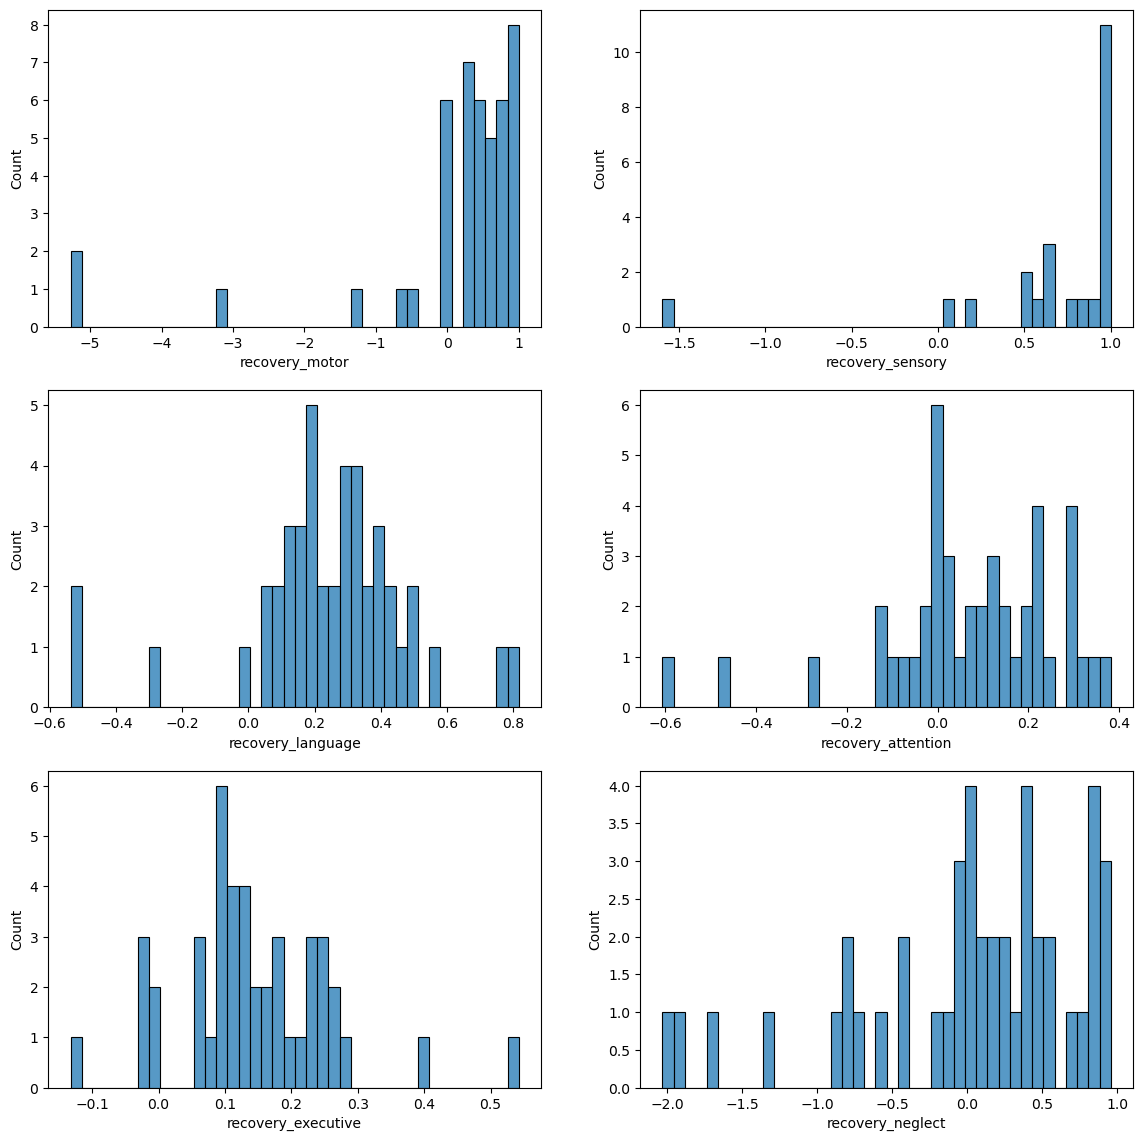

In [8]:
# We display the distribution of recovery for each domain
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i, domain in enumerate(domains):
    sns.histplot(recovery["recovery_"+domain], ax=ax[i%3, i%2], bins=40)
    #ax[i%3, i%2].set_xlim(-2.1,2)

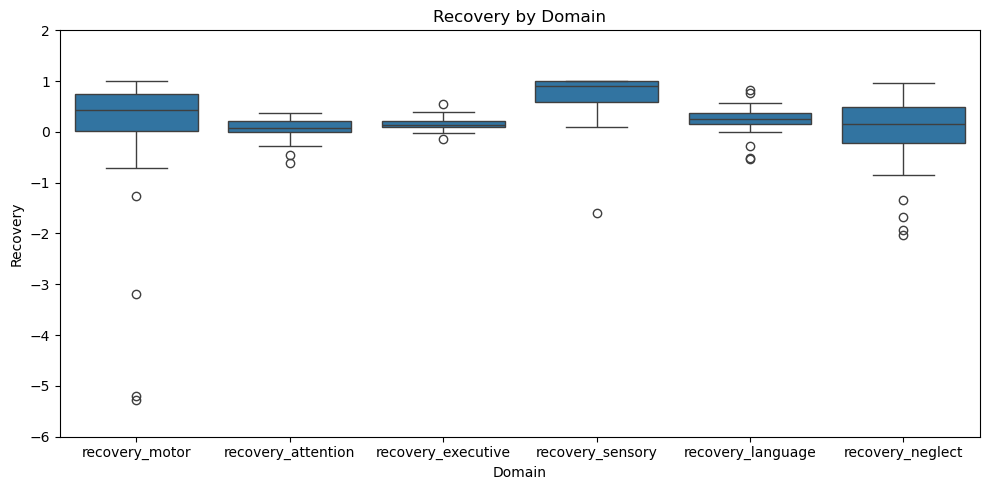

In [9]:
# Melt the recovery DataFrame to have a 'Domain' column for hue
melted_recovery = recovery.melt(var_name='Domain', value_name='Recovery', value_vars=[f"recovery_{domain}" for domain in domains])
#display(melted_recovery)

plt.figure(figsize=(10, 5))
sns.boxplot(data=melted_recovery, x='Domain', y='Recovery')
plt.ylim(-6 ,2)
plt.title('Recovery by Domain')
plt.tight_layout()
plt.show()

# We focus our interest on the motor recovery

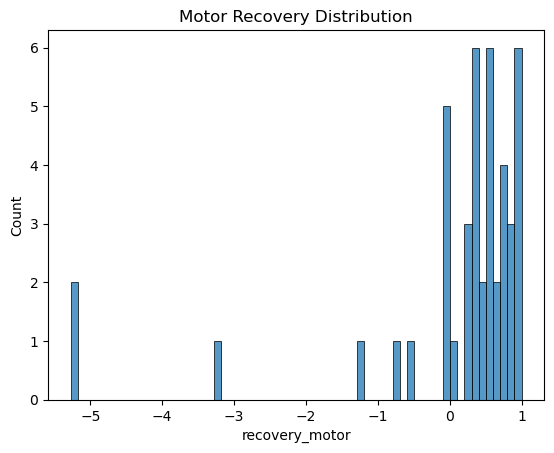

In [10]:
sns.histplot(recovery["recovery_motor"], binwidth=0.1)
plt.title('Motor Recovery Distribution');

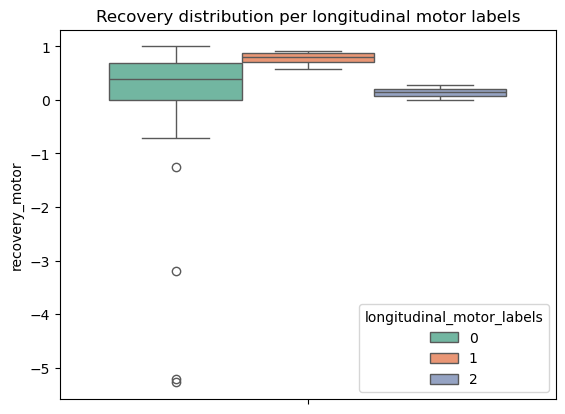

In [11]:
# Observe recovery per longitudinal labels

sns.boxplot(data=recovery,y=recovery["recovery_motor"], hue="longitudinal_motor_labels", palette=colormap)
plt.title("Recovery distribution per longitudinal motor labels");

### Let's observe behaviours of patients that have a negative motor recovery

,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor
Patient,,,,,,,,,,,
P001,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,0,1,1,0,-0.048907
P006,0.012982,0.387339,0.457463,0.012987,0.209198,0.059270,1,1,1,0,-0.555556
P008,0.035527,0.480300,0.546923,0.095238,0.404285,0.094135,1,1,1,0,-1.258135
P012,0.026386,0.279461,0.363271,0.014649,0.352002,0.020919,0,1,1,0,-0.019774
P016,0.000804,0.197349,0.298807,0.000000,0.184120,0.084298,0,1,1,0,-5.272120
P032,0.048080,0.374975,0.464582,0.021739,0.395952,0.078320,1,1,1,0,-0.718794
P039,0.002940,0.332126,0.265857,0.000000,0.296305,0.063541,0,1,1,0,-3.199912
P075,0.001588,0.254725,0.360441,0.000000,0.341510,0.121553,0,1,1,0,-5.204949
P076,0.024396,0.361476,0.421084,0.000000,0.390095,0.058034,1,1,1,0,-0.063480


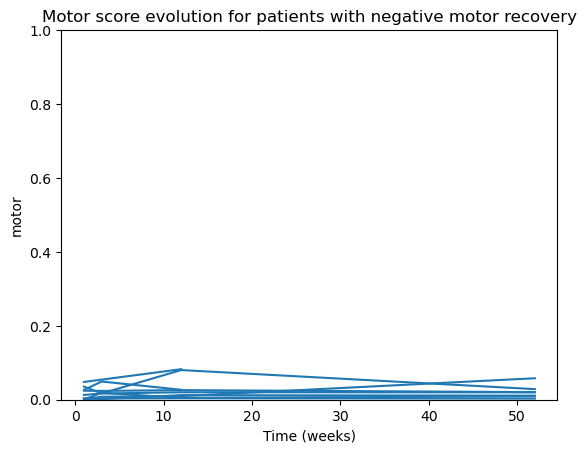

In [12]:
# Patients which have a motor recovery score below 0

motor_loss_patients = recovery[recovery["recovery_motor"] < 0].index.to_list()

for patient in motor_loss_patients:
    sns.lineplot(data=NMF[NMF["Patient"]==patient], x="time_in_weeks", y="motor", hue="Patient", legend = False, color='#1f77b4') 
plt.xlabel("Time (weeks)")
plt.ylim(0, 1)
plt.title("Motor score evolution for patients with negative motor recovery");


NMF_new_1 = NMF_new[NMF_new["time"] == "1"].set_index("Patient")
NMF_for_motor_loss = NMF_new_1.loc[motor_loss_patients]
NMF_for_motor_loss["recovery_motor"] = recovery.loc[motor_loss_patients]["recovery_motor"]
display(NMF_for_motor_loss)


### Let's observe behaviours of patients which were not impacted on the motor domain

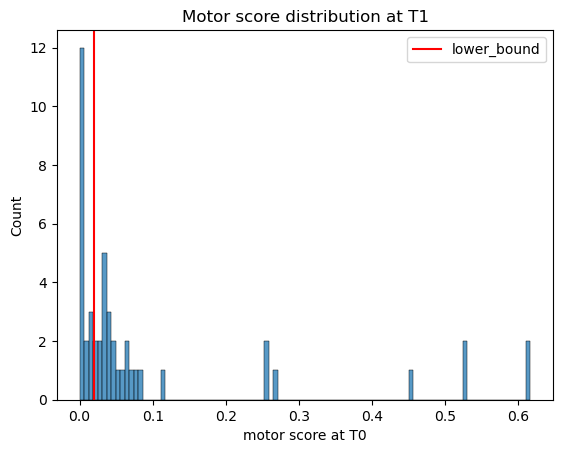

In [13]:
#Chosen lower_bound
lower_bound = 0.02

sns.histplot(NMF_new_1["motor"], bins =100)
plt.xlabel("motor score at T0")
plt.axvline(lower_bound, label="lower_bound", color="red")
plt.legend()
plt.title("Motor score distribution at T1")
plt.show()



Dataframe and correlations displayed for patients with motor score below the lower bound

,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor
Patient,,,,,,,,,,,
P001,0.003716,0.194499,0.295743,0.000000,0.288797,0.056766,0,1,1,0,-0.048907
P006,0.012982,0.387339,0.457463,0.012987,0.209198,0.059270,1,1,1,0,-0.555556
P013,0.001818,0.197541,0.166747,0.010989,0.272878,0.025119,0,1,1,0,0.448303
P014,0.003055,0.268100,0.445407,0.000000,0.267021,0.105673,0,1,1,0,0.385641
P016,0.000804,0.197349,0.298807,0.000000,0.184120,0.084298,0,1,1,0,-5.272120
P017,0.003200,0.221022,0.376948,0.010753,0.396777,0.046371,0,1,1,0,0.662525
P039,0.002940,0.332126,0.265857,0.000000,0.296305,0.063541,0,1,1,0,-3.199912
P041,0.012887,0.306817,0.401777,0.058824,0.323939,0.134492,0,1,1,0,0.762973
P050,0.003469,0.312251,0.367937,0.000000,0.295480,0.054327,0,1,1,0,0.536262


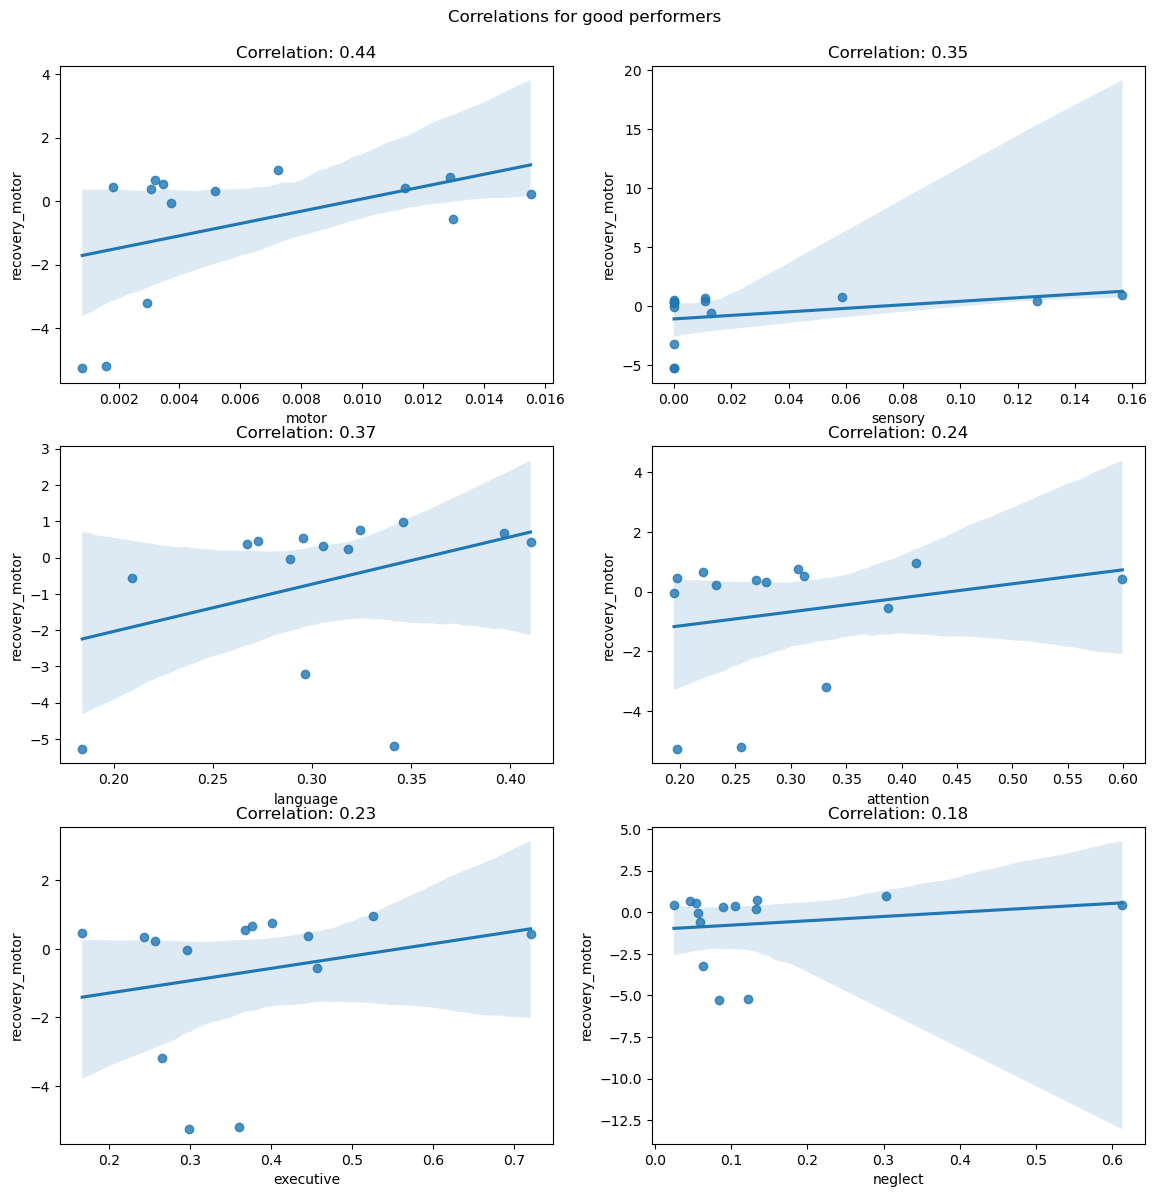

In [14]:
# We remove patients not affected by motor impairment
good_patients = NMF_new_1.loc[(NMF_new_1["motor"] <= lower_bound) & (NMF_new_1["motor"] != 0)]
NMF_for_motor_good = NMF_new_1.loc[good_patients.index.to_list()]
NMF_for_motor_good["recovery_motor"] = recovery.loc[good_patients.index.to_list()]["recovery_motor"]
display(NMF_for_motor_good)

fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i, domain in enumerate(domains):
    sns.regplot(x=domain, y="recovery_motor", data=NMF_for_motor_good, ax=ax[i%3, i%2])
    correlation_value = NMF_for_motor_good[[domain, "recovery_motor"]].corr().iloc[0, 1]
    ax[i%3, i%2].set_title(f'Correlation: {correlation_value:.2f}')
plt.suptitle("Correlations for good performers", y=0.92)
plt.show()

### After the removal of patients which were not impacted on the motor domain :

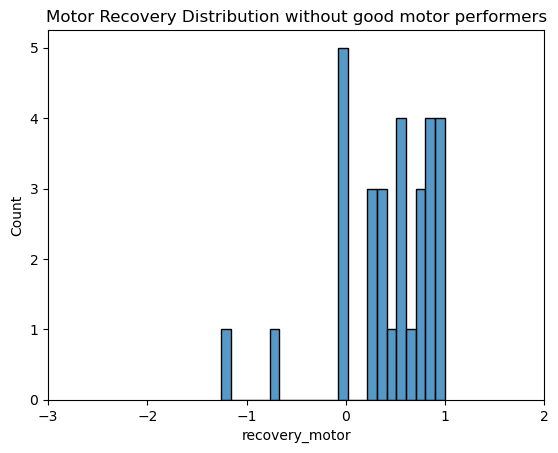

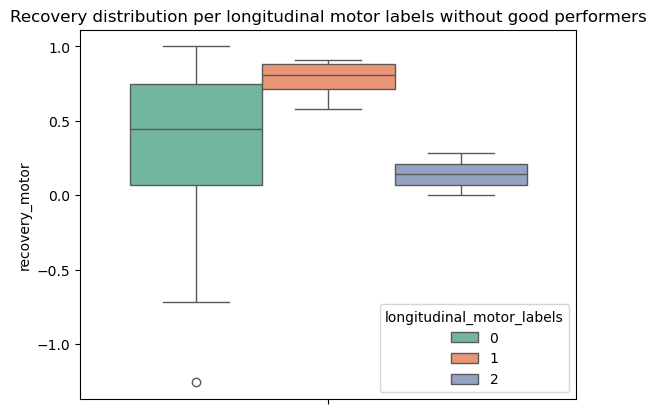

In [15]:
if remove_good_performers:
    
    # We remove patients not affected by motor impairment
    recovery_for_motor = recovery.drop(index=good_patients.index.to_list())
    removed_patients = good_patients.index.to_list()+ patients_to_remove.to_list()

else:
    # remove negative recovery
    if remove_negative:
        removed_patients = patients_to_remove.to_list() + motor_loss_patients
        recovery_for_motor = recovery.drop(index=motor_loss_patients)
    else:
        removed_patients = patients_to_remove.to_list() 
        recovery_for_motor = recovery

NMF_for_motor = NMF_new_1.drop(index=removed_patients)


#We add the variable of interest of the future linear model
NMF_for_motor["recovery_motor"] = recovery_for_motor["recovery_motor"]
NMF_for_motor["recovery_neglect"] = recovery_for_motor["recovery_neglect"]
NMF_for_motor["recovery_attention"] = recovery_for_motor["recovery_attention"]

sns.histplot(recovery_for_motor["recovery_motor"], binwidth=0.1)
plt.xlim(-3,2)
plt.title('Motor Recovery Distribution without good motor performers');
plt.show()


sns.boxplot(data=recovery_for_motor,y=recovery_for_motor["recovery_motor"], hue="longitudinal_motor_labels", palette=colormap)
plt.title("Recovery distribution per longitudinal motor labels without good performers");
plt.show()


In [16]:
# Total patients who were deleted for the linear model
print(removed_patients)
print(len(removed_patients))
#Total patients in the linear model
print(NMF_for_motor.shape[0])

['P001', 'P006', 'P013', 'P014', 'P016', 'P017', 'P039', 'P041', 'P050', 'P060', 'P075', 'P078', 'P080', 'P082', 'P021', 'P067', 'P068']
17
30


### About predictors

/tmp/ipykernel_14682/2619618470.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(predictors)


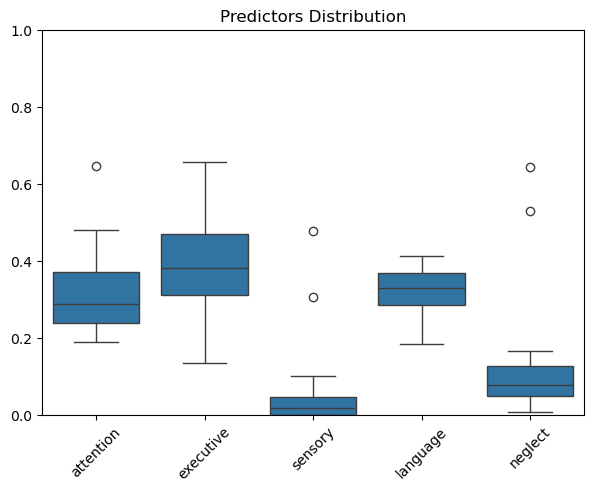

In [17]:
predictors = ["attention", "executive", "sensory", "language", "neglect"]
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=NMF_for_motor.drop(columns=["Labels", "time_in_weeks", "time", "recovery_motor", "longitudinal_motor_labels", "motor", "recovery_attention", "recovery_neglect"]), ax=ax, color='#1f77b4')
ax.set_ylim(0, 1)
ax.set_xticklabels(predictors)
plt.xticks(rotation=45)
plt.title('Predictors Distribution')
plt.show()

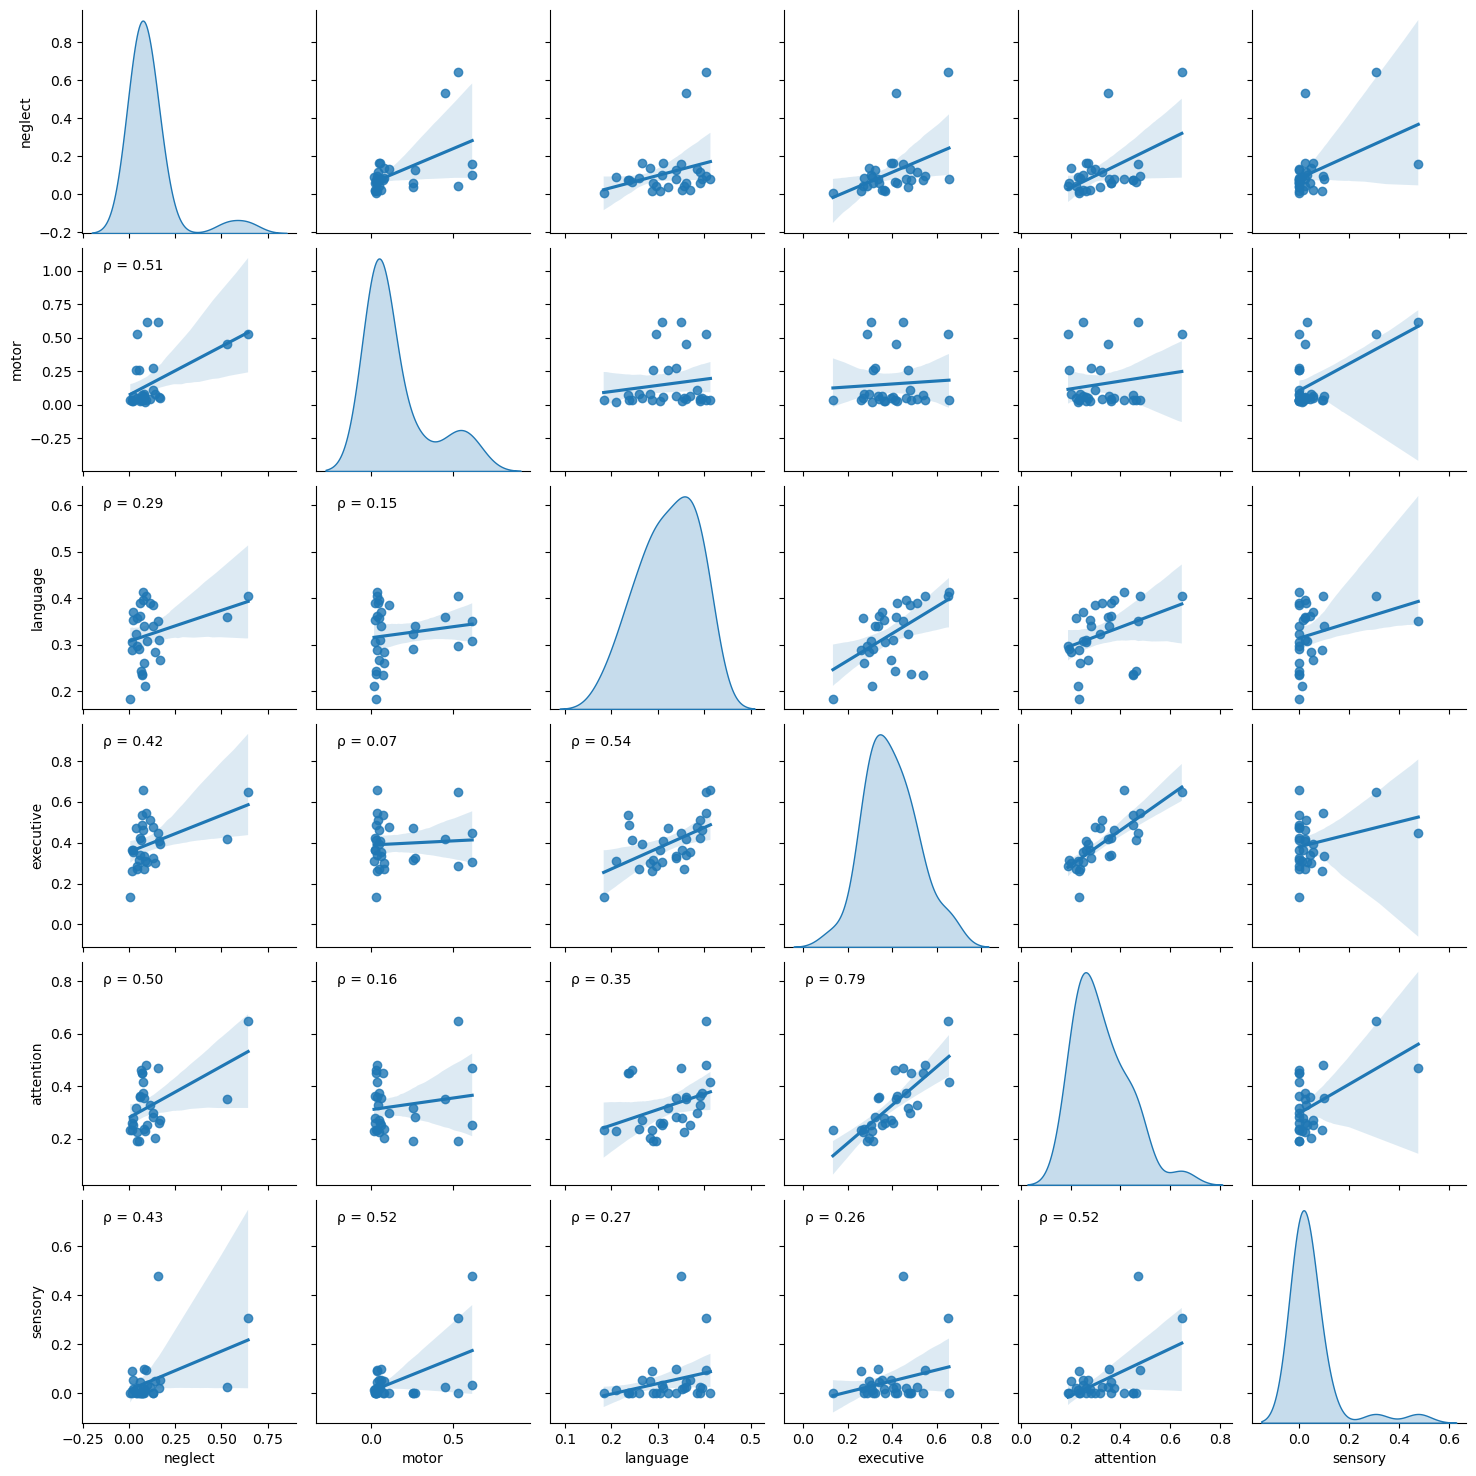

In [18]:
#scatterplot between every domains
domains_cor = ["neglect", "motor", "language", "executive", "attention", "sensory"]

def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

g=sns.pairplot(NMF_for_motor[domains_cor], diag_kind='kde', kind='reg')
g.map_lower(corrfunc)
plt.show()

Observation : At time T0, there is a very strong correlation between executive and attention

### First regression trial

In [19]:
mod = smf.ols(formula='recovery_motor ~ attention + executive + sensory + language + neglect + motor', data=NMF_for_motor)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         recovery_motor   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     2.083
Date:                Fri, 05 Jul 2024   Prob (F-statistic):             0.0950
Time:                        13:02:58   Log-Likelihood:                -15.534
No. Observations:                  30   AIC:                             45.07
Df Residuals:                      23   BIC:                             54.88
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7264      0.524      3.294      0.0

<ins>**Leverage to Help Identify Extreme x Values**</ins>

We can write the OLS predictions for y as $ŷ=Hy$ where H is the hat matrix
$H=X(X^{T}X)^{-1}X^{T}$

Thus each predicted response can be written as :
$ŷ_{i} = h_{i1}y_{1} + h_{i2}y_{2} + ... + h_{ii}y_{i} + ... + h_{in}y_{n}$

The **Leverage** $h_{ii}$ depends only on the predictor values $x_{ij}$ and quantifies the influence that the observed response $y_{i}$ has on its predicted value $ŷ_{ii}$

<ins>**Studentized Residuals to Help Identify Extreme x Values**</ins>


$t_i = \frac{e_{(i)}}{SE(e_{(i)})} = \frac{e_i}{\sqrt{MSE_{(i)}(1 - h_{ii})}}$

where $ e_{(i)} $ is the residual obtained when observation $ i $ is left out: $ y - \hat{y}_{(i)} $.


<ins>**Cook's distance**</ins>
Another useful diagnostic :
$D_k = \frac{1}{(p + 1) \hat{\sigma}^2} \sum_{i=1}^{n} (\hat{y}_{i(k)} - y_i)^2 $ \
Assess the impact of the kth observation on the estimated regression coefficient $\hat{\beta}_{i}$ \
The bigger the points in the following plot, the greater the Cook's distance

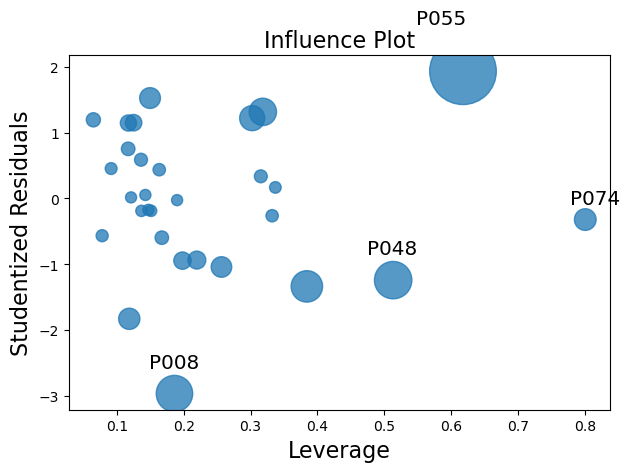

In [20]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

In [21]:
#Study of influential points if no preprocessing
if not remove_good_performers and not remove_negative:
    influencial_patients = ["P016","P039","P074","P075", "P048", "P078", "P055"]
    display(NMF_for_motor.loc[influencial_patients].drop(columns=["Labels", "time_in_weeks", "time"]))
    sns.lineplot(data=NMF[NMF["Patient"].isin(influencial_patients)],x="time_in_weeks",y="motor", hue="longitudinal_motor_labels", palette=colormap)
else:
    print("If we remove good performers, we can observe that P055 is the most influential point in terms of studentized residudals, leverage and Cook's distance")


If we remove good performers, we can observe that P055 is the most influential point in terms of studentized residudals, leverage and Cook's distance


### Second Regression Trial

In [22]:
if LAST_scores_no_language:
    formula = 'recovery_motor ~ attention + sensory + neglect'
else:
    formula='recovery_motor ~ attention + language + neglect'

In [23]:
# Second regression model
mod = smf.ols(formula=formula, data=NMF_for_motor)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         recovery_motor   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     3.973
Date:                Fri, 05 Jul 2024   Prob (F-statistic):             0.0186
Time:                        13:02:58   Log-Likelihood:                -16.383
No. Observations:                  30   AIC:                             40.77
Df Residuals:                      26   BIC:                             46.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8067      0.465      3.882      0.0

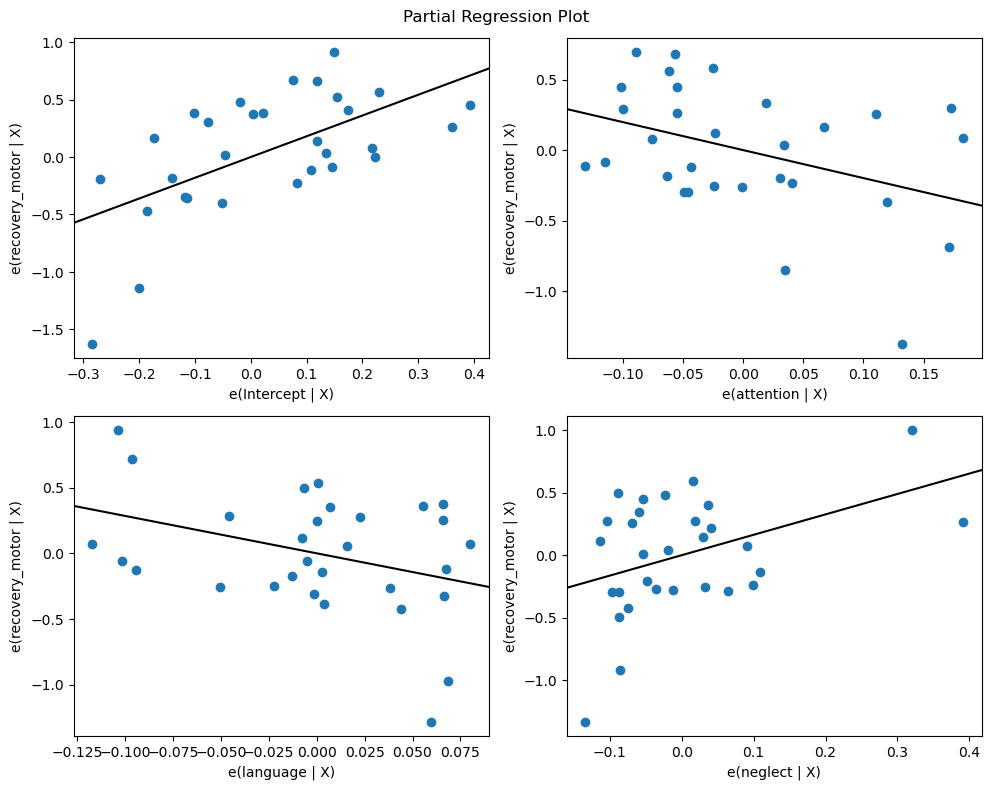

In [24]:
fig = plt.figure(figsize=(10,8))
sm.graphics.plot_partregress_grid(res, fig=fig)
fig.tight_layout(pad=1.0)

### Let's observe correlations of predictors vs motor recovery

['motor', 'attention', 'executive', 'sensory', 'language', 'neglect']


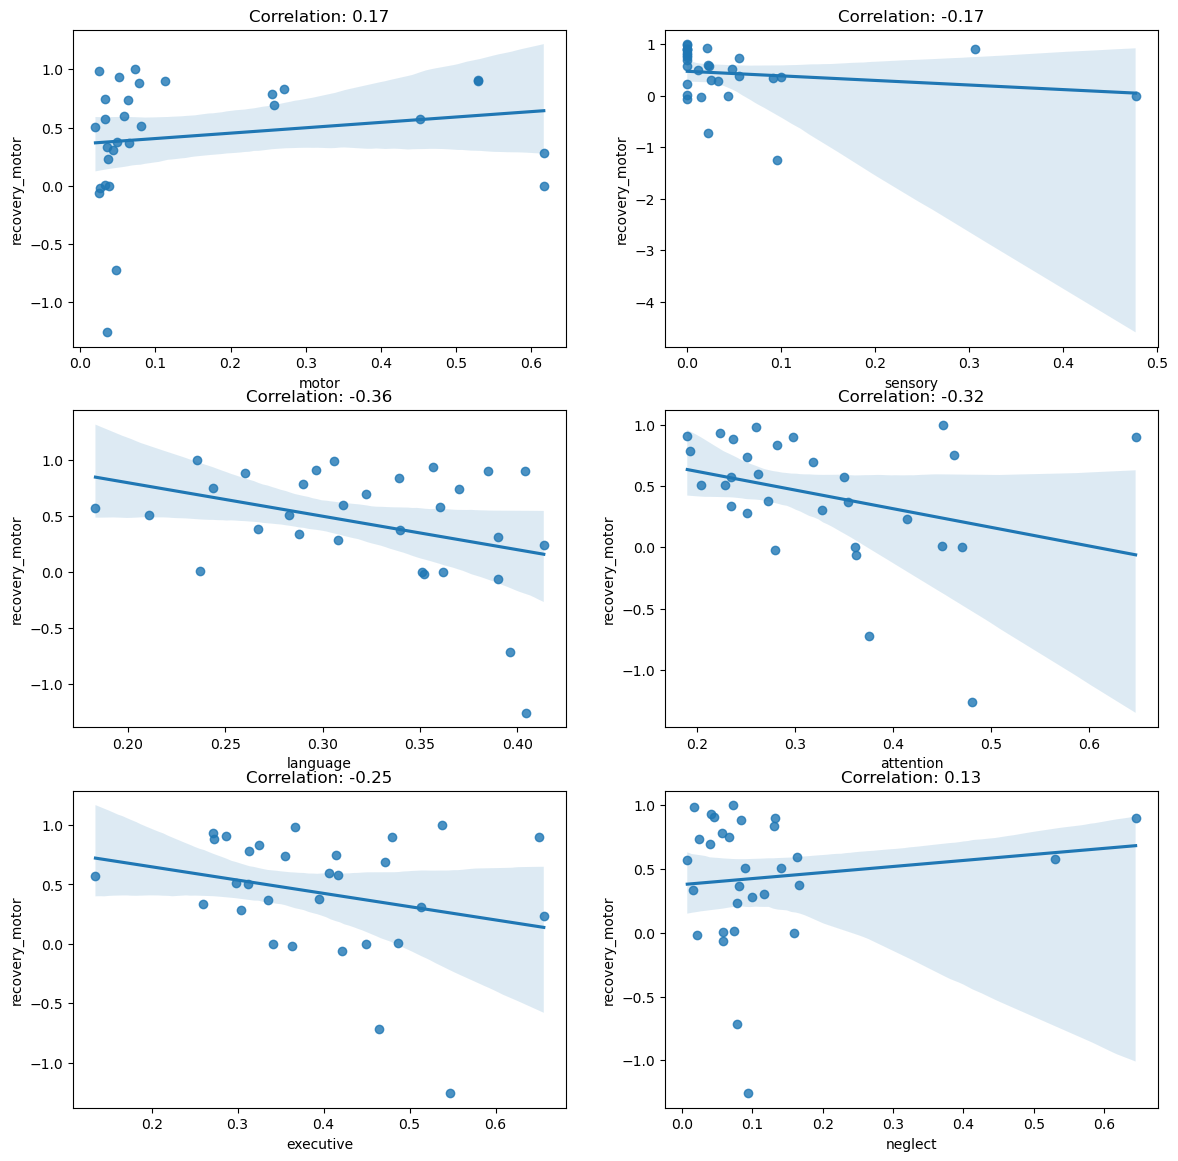

In [25]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i, domain in enumerate(domains):
    sns.regplot(x=domain, y="recovery_motor", data=NMF_for_motor, ax=ax[i%3, i%2])
    correlation_value = NMF_for_motor[[domain, "recovery_motor"]].corr().iloc[0, 1]
    ax[i%3, i%2].set_title(f'Correlation: {correlation_value:.2f}')
print(domains)

### Let's observe common outliers between predictors and influential points

/tmp/ipykernel_14682/1203741366.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(predictors)


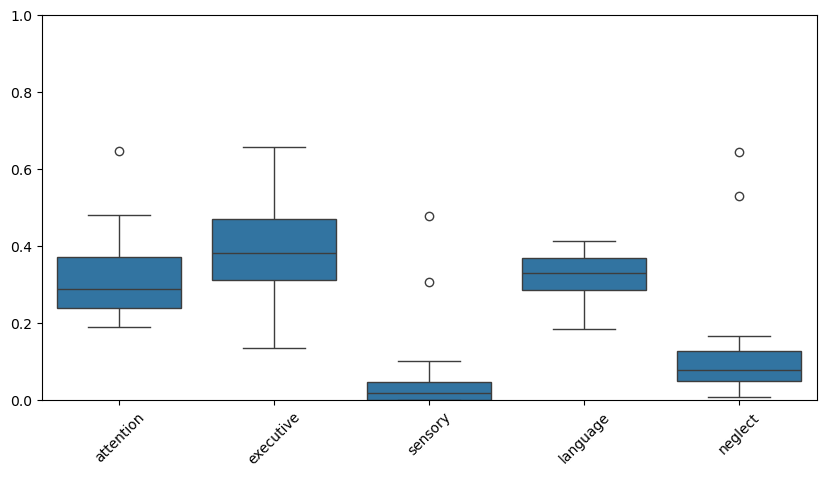

In [26]:
predictors = ["attention", "executive", "sensory", "language", "neglect"]
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=NMF_for_motor.drop(columns=['longitudinal_motor_labels', "Labels", "time_in_weeks", "time", "recovery_motor", "motor", "recovery_attention", "recovery_neglect"]), ax=ax, color = '#1f77b4')
ax.set_ylim(0, 1)
ax.set_xticklabels(predictors)
plt.xticks(rotation=45)
plt.show()

In [27]:
motor_outliers = NMF_for_motor[NMF_for_motor["motor"] > 0.5]
display(motor_outliers)

attention_outliers = NMF_for_motor[NMF_for_motor["attention"] > 0.5]
display(attention_outliers)

sensory_outliers = NMF_for_motor[NMF_for_motor["sensory"] > 0.3]
display(sensory_outliers)

neglect_outliers = NMF_for_motor[NMF_for_motor["neglect"] > 0.5]
display(neglect_outliers)

,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor,recovery_neglect,recovery_attention
Patient,,,,,,,,,,,,,
P019,0.616390,0.250894,0.303605,0.032258,0.308019,0.098964,2,1,1,2,0.281486,-0.450220,0.030991
P055,0.528425,0.647255,0.650434,0.305556,0.403887,0.644716,3,1,1,1,0.896619,0.791623,0.306297
P073,0.529577,0.189729,0.286234,0.000000,0.296305,0.045249,2,1,1,1,0.905091,0.053899,0.028692
P074,0.616390,0.469939,0.449094,0.476923,0.350747,0.158380,3,1,1,2,0.000000,0.413408,0.002972


,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor,recovery_neglect,recovery_attention
Patient,,,,,,,,,,,,,
P055,0.528425,0.647255,0.650434,0.305556,0.403887,0.644716,3,1,1,1,0.896619,0.791623,0.306297


,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor,recovery_neglect,recovery_attention
Patient,,,,,,,,,,,,,
P055,0.528425,0.647255,0.650434,0.305556,0.403887,0.644716,3,1,1,1,0.896619,0.791623,0.306297
P074,0.616390,0.469939,0.449094,0.476923,0.350747,0.158380,3,1,1,2,0.000000,0.413408,0.002972


,motor,attention,executive,sensory,language,neglect,Labels,time,time_in_weeks,longitudinal_motor_labels,recovery_motor,recovery_neglect,recovery_attention
Patient,,,,,,,,,,,,,
P048,0.452340,0.349944,0.416603,0.022727,0.359985,0.530817,2,1,1,1,0.576267,0.813624,0.301363
P055,0.528425,0.647255,0.650434,0.305556,0.403887,0.644716,3,1,1,1,0.896619,0.791623,0.306297


Patient 55 is a common outlier \
If we remove good performers, this point is also the most influential point

In [28]:
if remove_good_performers: 
    influential_index = ["P055", "P048"]
elif not remove_negative:
    influential_index = ["P039","P075","P016","P074"]

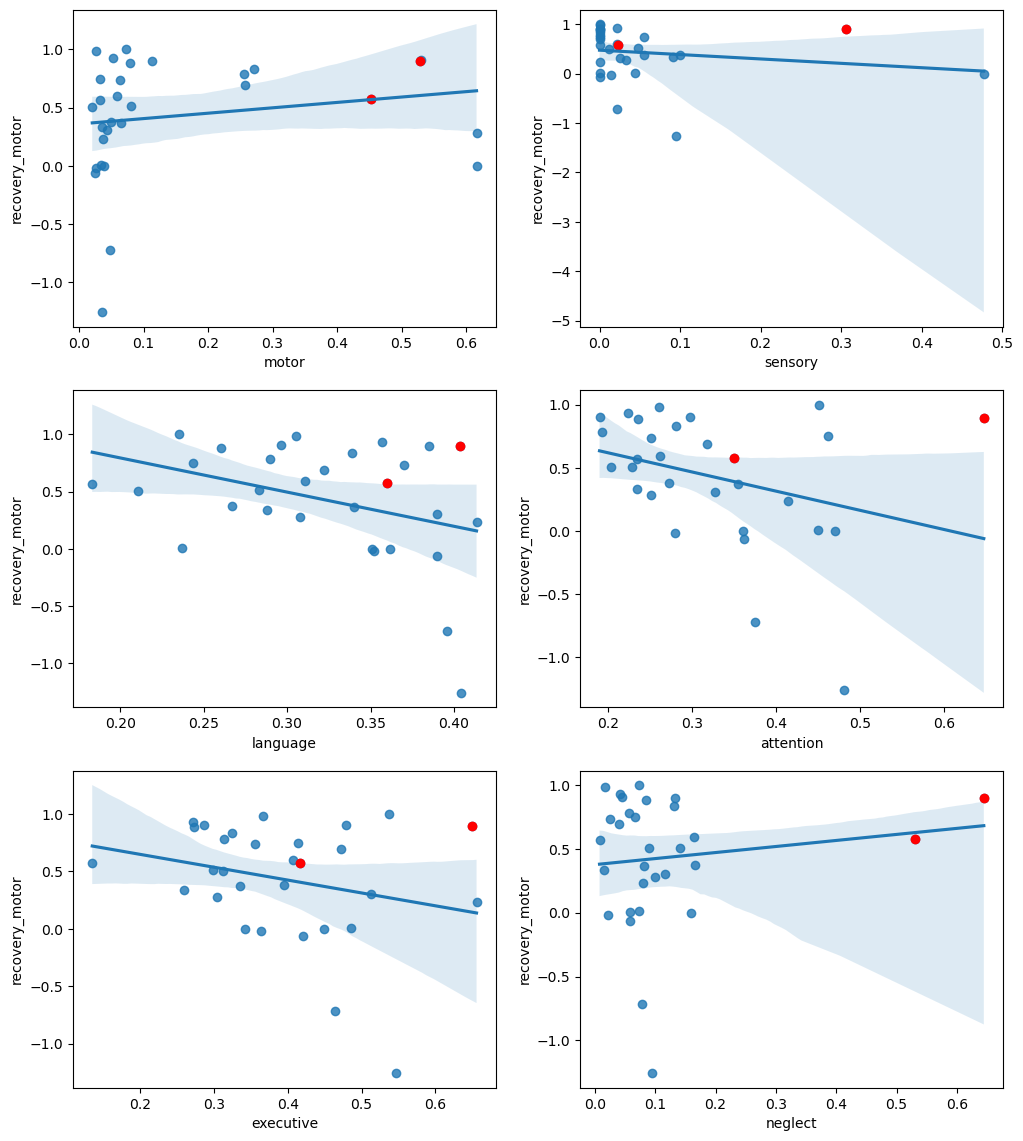

In [29]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(12, 14))

for i, domain in enumerate(domains):
    sns.regplot(x=domain, y="recovery_motor", data=NMF_for_motor, ax=ax[i % 3, i % 2])
    
    # Highlight the specific indexes       
    ax[i % 3, i % 2].scatter(
        np.array(NMF_for_motor.loc[influential_index, domain].to_list()),
        np.array(NMF_for_motor.loc[influential_index, "recovery_motor"].to_list()),
        color='red'  
    )


/tmp/ipykernel_14682/3067841197.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(data=NMF[NMF["Patient"].isin(influential_index)], x="time_in_weeks", y="motor", hue="Patient", legend = True, palette=sns.color_palette("husl", 8))


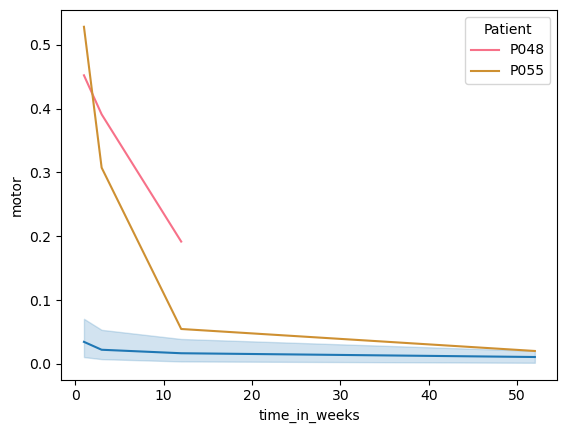

,longitudinal_motor_labels,recovery_motor,recovery_attention,recovery_executive,recovery_sensory,recovery_language,recovery_neglect
Patient,,,,,,,
P055,1,0.896619,0.306297,0.542632,1.0,0.173031,0.791623
P048,1,0.576267,0.301363,0.256044,1.0,0.406967,0.813624


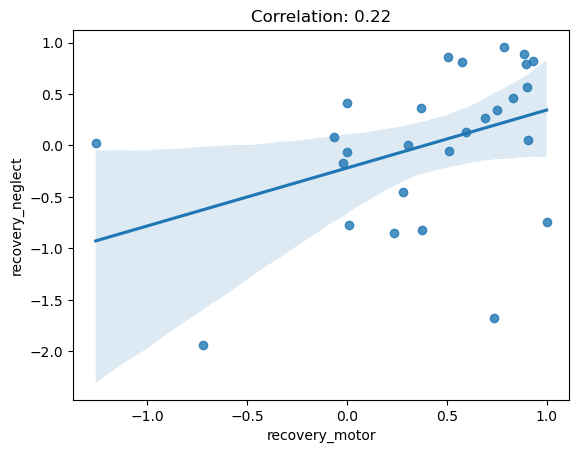

Text(0.5, 1.0, 'Correlation: -0.04')

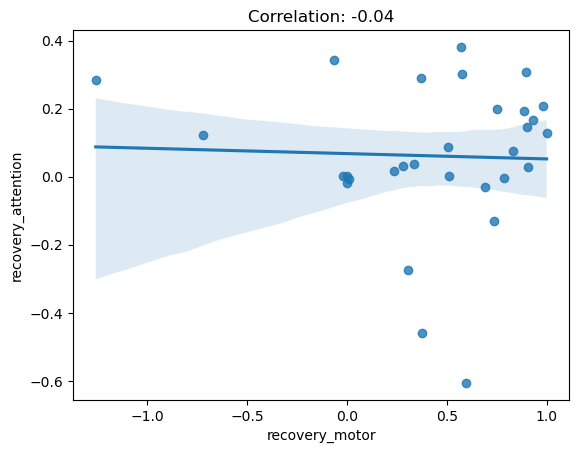

In [30]:
sns.lineplot(data=NMF, x="time_in_weeks", y="motor", estimator = "median", errorbar=("pi", 50))
sns.lineplot(data=NMF[NMF["Patient"].isin(influential_index)], x="time_in_weeks", y="motor", hue="Patient", legend = True, palette=sns.color_palette("husl", 8)) 
plt.show()
display(recovery.loc[influential_index])

#correlation between recovery motor and recovery neglect
indices_to_drop = NMF_new_1.loc[NMF_new_1["neglect"] <= lower_bound].index
NMF_for_motor_neglect = NMF_for_motor.drop(indices_to_drop.intersection(NMF_for_motor.index))
sns.regplot(x="recovery_motor", y="recovery_neglect", data=NMF_for_motor_neglect)
correlation_value = NMF_for_motor[["recovery_motor", "recovery_neglect"]].corr().iloc[0, 1]
plt.title(f'Correlation: {correlation_value:.2f}')
plt.show()

#correlation between recovery motor and recovery attention
sns.regplot(x="recovery_motor", y="recovery_attention", data=NMF_for_motor)
correlation_value = NMF_for_motor[["recovery_motor", "recovery_attention"]].corr().iloc[0, 1]
plt.title(f'Correlation: {correlation_value:.2f}')


/tmp/ipykernel_14682/445713005.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.lineplot(data=NMF[NMF["Patient"].isin(influential_index)], x="time_in_weeks", y="neglect", hue="Patient", palette=sns.color_palette("husl", 8), legend = True)


<Axes: xlabel='time_in_weeks', ylabel='neglect'>

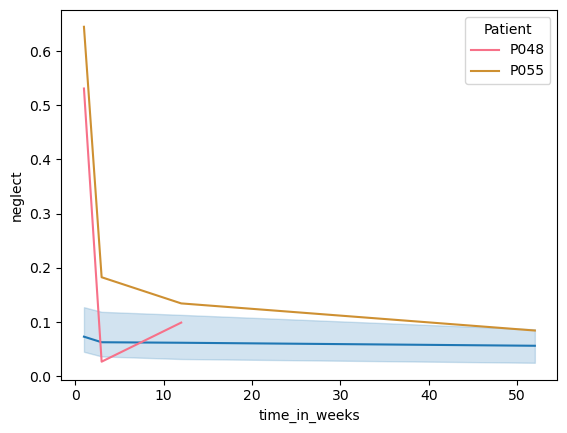

In [31]:
sns.lineplot(data=NMF, x="time_in_weeks", y="neglect", estimator = "median", errorbar=("pi", 50))
sns.lineplot(data=NMF[NMF["Patient"].isin(influential_index)], x="time_in_weeks", y="neglect", hue="Patient", palette=sns.color_palette("husl", 8), legend = True)

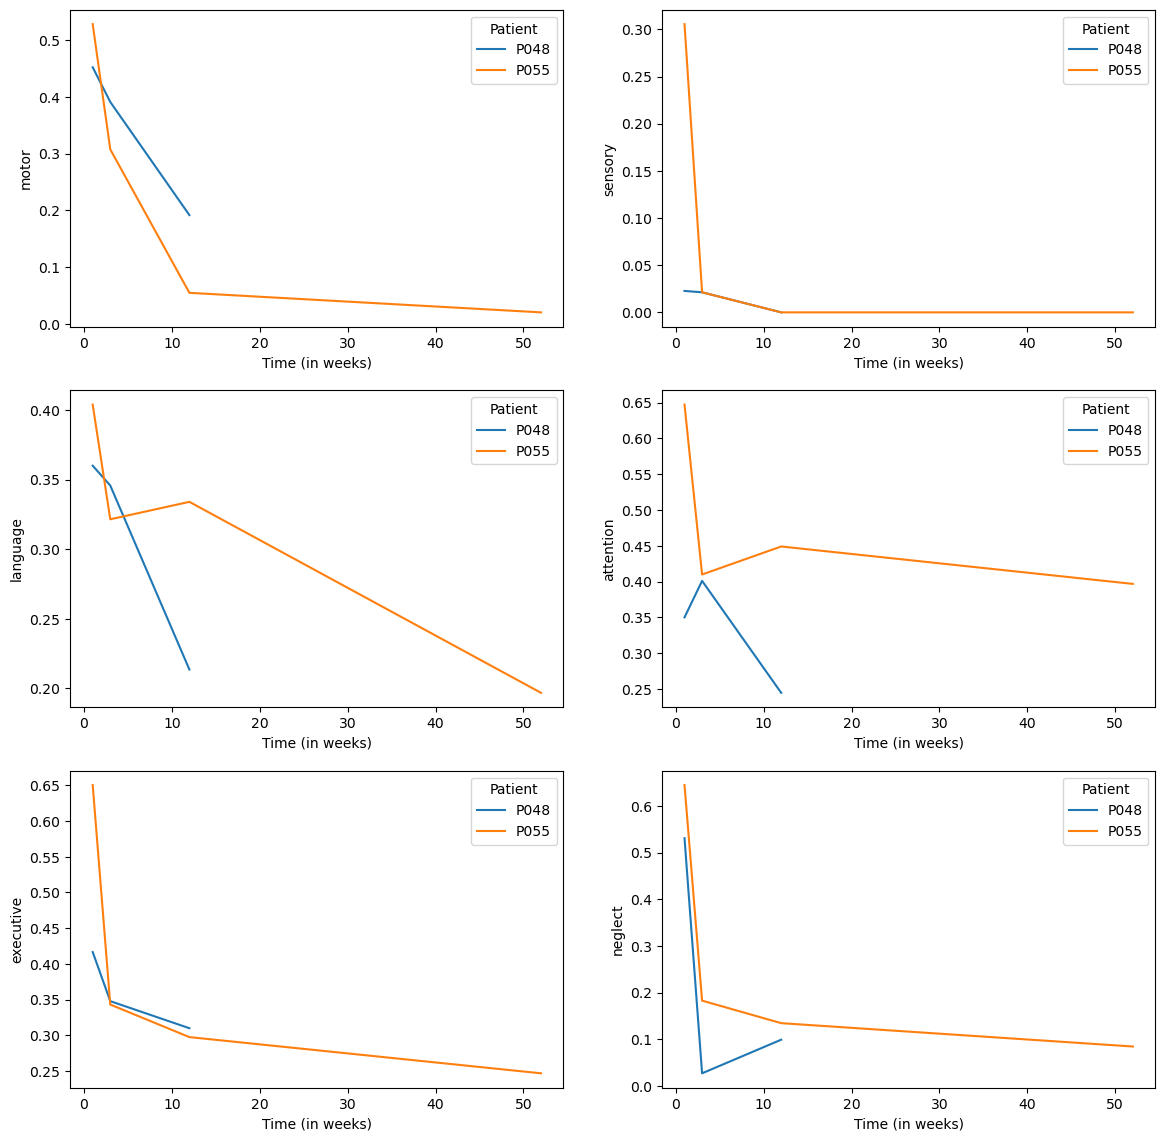

In [32]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
for i in range(n_domains):
    sns.lineplot(data=NMF[NMF["Patient"].isin(influential_index)], x="time_in_weeks", y=domains[i], ax=ax[i%3, i%2], hue="Patient", palette="tab10", legend = True) 
    ax[i%3, i%2].set_xlabel("Time (in weeks)")

### By removing influential points 

/tmp/ipykernel_14682/3686735068.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(predictors)


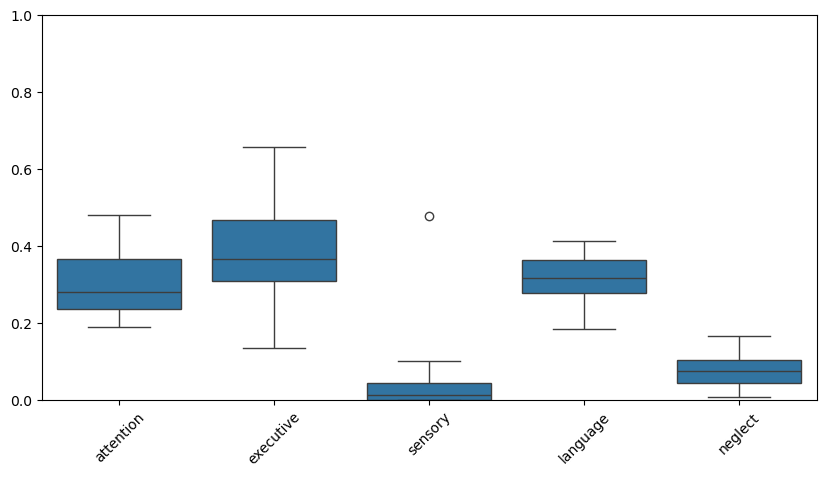

In [33]:
NMF_for_motor = NMF_for_motor.drop(index = influential_index)

if remove_good_performers:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=NMF_for_motor.drop(columns=['longitudinal_motor_labels', "Labels", "time_in_weeks", "time", "recovery_motor", "motor", "recovery_attention", "recovery_neglect"]), ax=ax, color='#1f77b4')
    ax.set_ylim(0, 1)
    ax.set_xticklabels(predictors)
    plt.xticks(rotation=45)
    plt.show()

['motor', 'attention', 'executive', 'sensory', 'language', 'neglect']


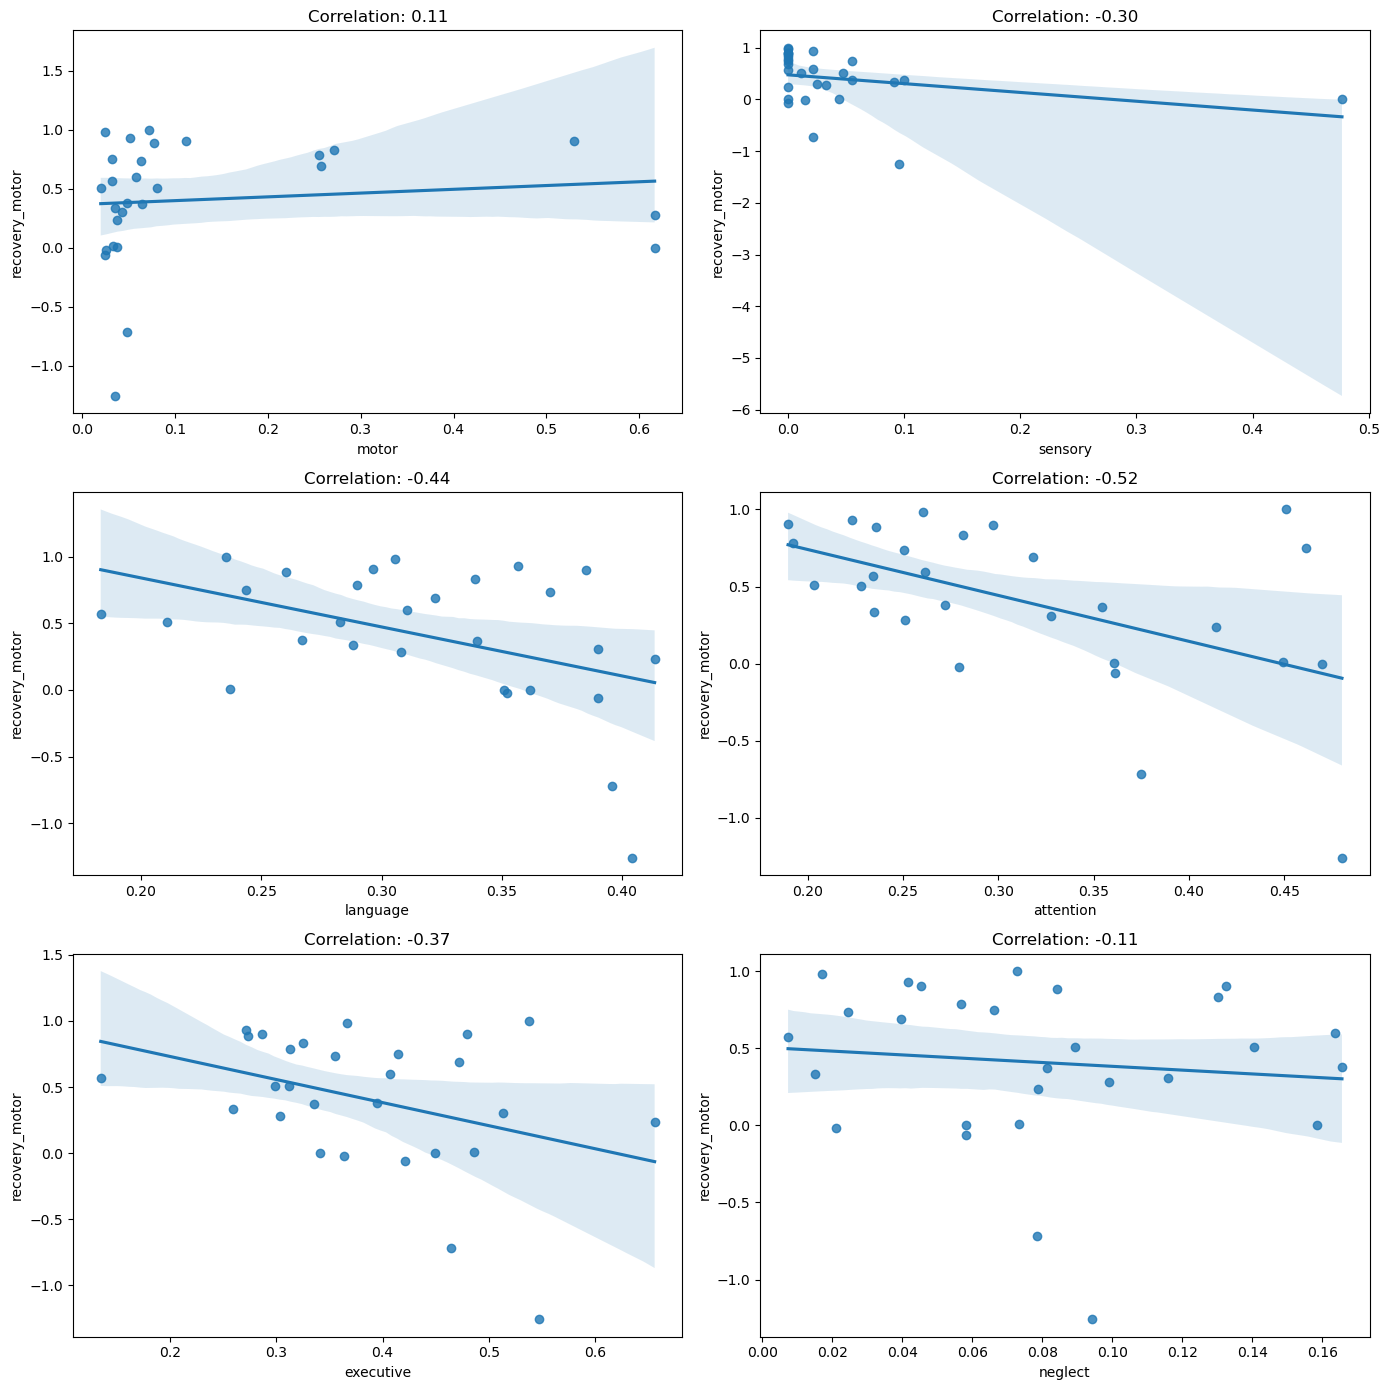

In [34]:
fig, ax = plt.subplots(n_domains//2, n_domains//3, figsize=(14,14))
print(domains)
for i, domain in enumerate(domains):
    sns.regplot(x=domain, y="recovery_motor", data=NMF_for_motor, ax=ax[i%3, i%2])
    correlation_value = NMF_for_motor[[domain, "recovery_motor"]].corr().iloc[0, 1]
    ax[i%3, i%2].set_title(f'Correlation: {correlation_value:.2f}')

plt.tight_layout()
plt.show()

### New Regression

In [35]:
mod = smf.ols(formula='recovery_motor ~ attention + executive + sensory + language + neglect', data=NMF_for_motor)
np.random.seed(2)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         recovery_motor   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     3.128
Date:                Fri, 05 Jul 2024   Prob (F-statistic):             0.0278
Time:                        13:03:01   Log-Likelihood:                -13.551
No. Observations:                  28   AIC:                             39.10
Df Residuals:                      22   BIC:                             47.10
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1668      0.530      4.090      0.0

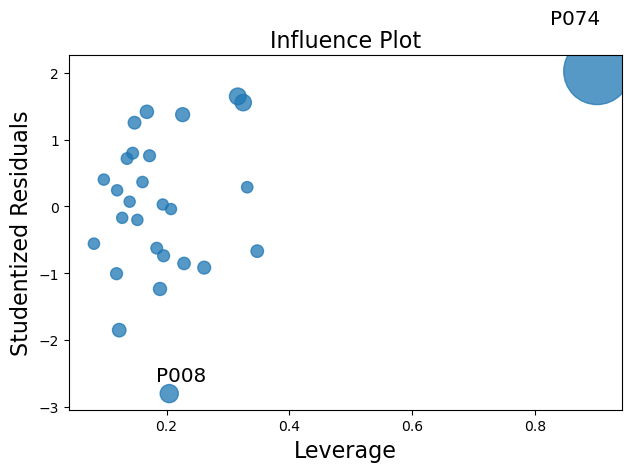

In [36]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

### Best model with the 3 best predictors (highest correlation on the regplot and p-value on the regression model)

In [37]:
if remove_good_performers:
    formula='recovery_motor ~ language + attention + executive'
    if LAST_scores_no_language:
        formula = 'recovery_motor ~ attention + sensory + neglect'
elif not remove_negative:
    formula='recovery_motor ~ language + attention + neglect'

In [38]:
mod = smf.ols(formula=formula, data=NMF_for_motor)
np.random.seed(2)
res = mod.fit()
print(res.summary())

#higher loglikelihood = better fit

                            OLS Regression Results                            
Dep. Variable:         recovery_motor   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     5.627
Date:                Fri, 05 Jul 2024   Prob (F-statistic):            0.00457
Time:                        13:03:01   Log-Likelihood:                -13.613
No. Observations:                  28   AIC:                             35.23
Df Residuals:                      24   BIC:                             40.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1412      0.465      4.609      0.0

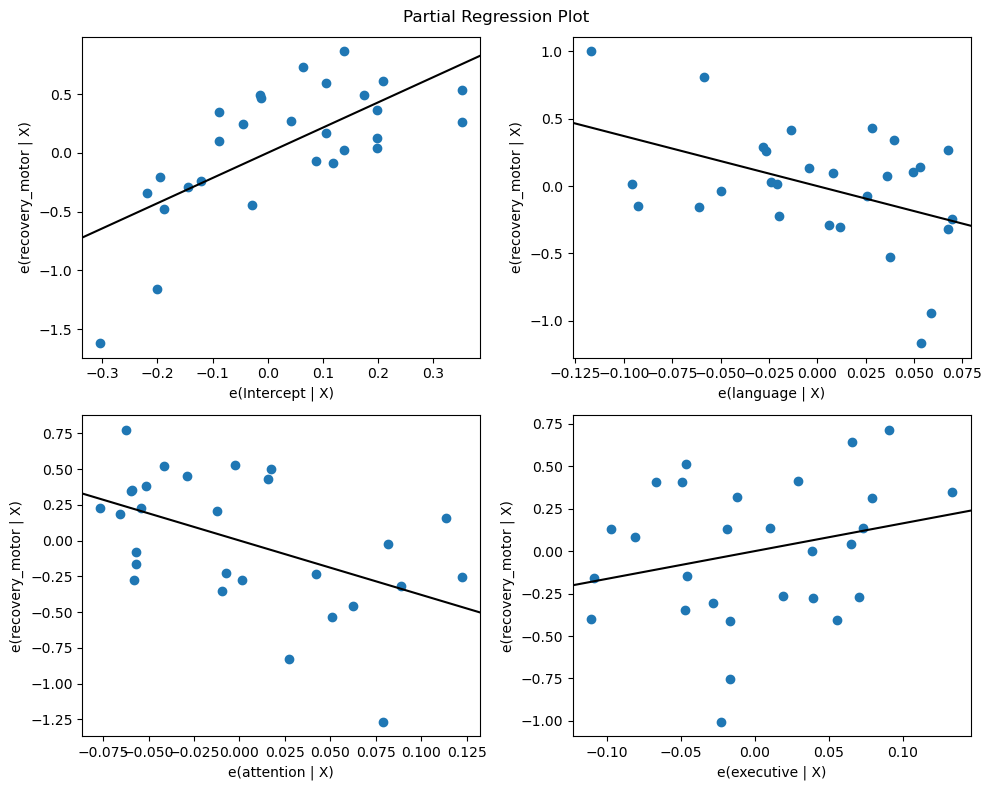

In [39]:
fig = plt.figure(figsize=(10,8))
sm.graphics.plot_partregress_grid(res, fig=fig)
fig.tight_layout(pad=1.0)